<a href="https://colab.research.google.com/github/nyp-sit/sdaai-iti107/blob/main/session-7/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Baseline model

Welcome to this week's programming exercise. In this exercise, we will be training a model to recognise if an image depicts positive (e.g. happy, pleasant, beautiful) or negative (e.g. sad, angry, death, etc) emotion . We will first train a baseline model without using transfer learning. The dataset is a collection of around 1600 images from Flickr, and labelled with Positive or Negative label. We only apply data augmentation to our training set. In the next exercise, we will use transfer learning technique to train another model and compare the performance of both.

At the end of this exercise, you will be able to: 
- use ImageDataGenerator to generate augmented images from directory 
- understand typical directory structure expected by the ImageDataGenerator
- train a convolutional neural network using the ImageDataGenerator
- visualize the training/validation loss/accuracy over training epochs

In [3]:
from __future__ import print_function

import os
import json
import shutil
import numpy as np

#from utils import *
from utils import prepare_data, download_trained_model_and_history

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
import pickle
import tqdm

%matplotlib inline

## Preparing Data

To avoid cluttering the codes in the notebook, we put the `prepare_data()` code in a separate python file. This function prepare the directory structure (by creating a **train** and **valid** subfolders under `data_path` directory for holding the train and validation data respectively). It also automatically unzip and copy the image files into 'Negative' and 'Positive' subfolders of the training and validation folder.

In [8]:
dataset_URL = 'https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/iti107/datasets/intel_emotions_dataset.zip'
path_to_zip = tf.keras.utils.get_file('intel.zip', origin=dataset_URL, extract=True, cache_dir='.')
print(path_to_zip)

504274944/504272804 [==============================] - 26s 0us/step
.\datasets\intel.zip


In [16]:
dataset_dir = os.path.dirname(path_to_zip)
print(dataset_dir)
pos_path = os.path.join(dataset_dir, 'Positive')
neg_path = os.path.join(dataset_dir, 'Negative')

.\datasets


We randomly select `n_examples` and display them.

In [24]:
print(len(os.listdir(pos_path))+len(os.listdir(neg_path)))
1630*0.2

1630


326.0

In [12]:
n_examples = 5
np.random.seed(42)
positive_expamples = np.random.choice(os.listdir(pos_path), size=n_examples, replace=False)
negative_expamples = np.random.choice(os.listdir(neg_path), size=n_examples, replace=False)

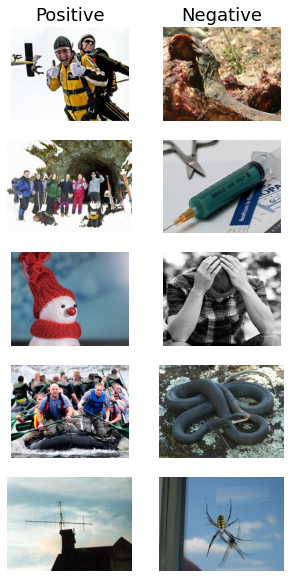

In [14]:
plt.figure(figsize=(5, n_examples * 2))
for i in range(n_examples):
    plt.subplot(n_examples, 2, i * 2 + 1)
    img = load_img(os.path.join(pos_path, positive_expamples[i]))
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title("Positive", fontsize=18)
    plt.subplot(n_examples, 2, i * 2 + 2)
    img = load_img(os.path.join(neg_path, negative_expamples[i]))
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title("Negative", fontsize=18)

## Create a Data Generator

We will use the tf.keras ImageDataGenerator to serve the training and validation data from the directory. For the training data, we will apply some data augmentation techniques such as rotaion, shifting, shearing, etc. We will also need to normalize the image pixel values to between 0.0 and 1.0. 

***Note about Python generator***

A Python generator is an object that acts as an iterator: it’s an object you can use
with the `for … in` loop. Generators are built using the yield operator.

In [15]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2)

**Exercise**

Create an ImageDataGenerator for validation data too. Do you need to apply data transformation for validation data?

<details><summary>Click here for answer</summary>

We only apply transformation for training data, and not validation data.

valid_datagen =  ImageDataGenerator(rescale=1./255)

</details>

In [64]:
### START YOUR CODE HERE ###
img_height, img_width = 200, 200

train_gen = datagen.flow_from_directory(
        # This is the target directory
        dataset_dir,
        # All images will be resized to 150x150
        target_size=(img_height, img_width),
        batch_size=32,
        shuffle=True,
        seed=110,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse',
        subset='training')

validation_gen = datagen.flow_from_directory(
        dataset_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        shuffle=True,
        seed=30,
        class_mode='sparse',
        subset='validation')

### END YOUR CODE HERE ###

Found 1305 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


We use `flow_from_directory()` method to generate batches of data from the specified train and validation directory. The directory should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.  Since we only have 2 classes, we specify `class_mode` as 'binary' so that the generator will return the binary labels (0 and 1). The class name mapping for the labels will be based on the names of the subdirectories (in our case 'Negative' and 'Positive'). The `batch_size` determines how many samples are returned by the generator on each iteration.

See [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for more details of the different parameters.

In [61]:
img_height, img_width = 200, 200

# train_gen = train_datagen.flow_from_directory(train_path, 
#                                               target_size=(img_height, img_width), 
#                                               class_mode="binary", 
#                                               batch_size=64, 
#                                               shuffle=True, 
#                                               seed=21)

# valid_gen = valid_datagen.flow_from_directory(valid_path, 
#                                               target_size=(img_height, img_width), 
#                                               class_mode="binary", 
#                                               batch_size=64, 
#                                               shuffle=False, 
#                                               seed=21)

In [62]:
# Print the class names to class labels mapping
print(validation_gen.class_indices)
print(train_gen.class_indices)

{'Negative': 0, 'Positive': 1}
{'Negative': 0, 'Positive': 1}


If you are running this on non-GPU, the training could take quite a while. To save time, you can set LOAD_BASELINE_MODEL = True and it will download the model we have previously trained as well as the training history to the current directory

In [34]:
LOAD_BASELINE_MODEL = False

if LOAD_BASELINE_MODEL: 
    #download_trained_model_and_history(os.path.join(models_path, 'baseline.model'))
    download_trained_model_and_history(os.path.join(models_path, "baseline.model.h5"))

In [66]:
if LOAD_BASELINE_MODEL:
    try:
        model_baseline = load_model(os.path.join(models_path, "baseline.model.h5"))
        print("Model has been loaded!")
    except:
        LOAD_BASELINE_MODEL = False
        print("Load has failed. Model will be built from scratch.")
        
if not LOAD_BASELINE_MODEL:
    
    inp = Input(shape=train_gen.target_size + (3,))

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2))(inp)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2))(conv1)
    maxpool1 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2))(maxpool1)
    conv4 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2))(conv3)
    maxpool2 = MaxPool2D(pool_size=(2, 2))(conv4)

    flattened = Flatten()(maxpool2)
    
    fc1 = Dense(units=256, activation="relu", 
                kernel_initializer="he_normal")(flattened)
    dp1 = Dropout(rate=0.5)(fc1)
    
    fc2 = Dense(units=512, activation="relu", 
                kernel_initializer="he_normal")(dp1)
    dp2 = Dropout(rate=0.5)(fc2)
    
    out = Dense(units=1, activation="sigmoid")(dp2)
    
    model_baseline = Model(inputs=[inp], outputs=[out])
    
    model_baseline.compile(optimizer="Adam", 
                           loss="binary_crossentropy", 
                           metrics=["accuracy"])
    
    print("Model has been built.")

Model has been built.


In [67]:
model_baseline.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 99, 99, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 49, 49, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0   

## Train the model

Because data is drawn endlessly from generator, you need to tell Keras model how many samples to draw from generator before declaring an epoch is over. This is the the role of `steps_per_epoch`. 

Below, we set the `steps_per_epoch` to be equal to 'number of samples/batch size'. However, this is kind of arbitrary, and it does not mean the generator will return all the images available in the directory. For example, if we have 100 different images in the directory and our batch size is 10, our steps_per_epoch = 100/10, i.e. 10. However, after 10 steps of 10 images, for a total of 100 generated images, not all the original 100 images in the directory will be used. This is because ImageDataGenerator randomly transforms the images, and you may get two slightly transformed versions of the same image, instead of 2 different images.

In [68]:
train_steps_per_epoch = int(np.ceil(train_gen.n * 1. / train_gen.batch_size))
validation_steps_per_epoch = int(np.ceil(validation_gen.n * 1. / validation_gen.batch_size))

In [69]:
if not LOAD_BASELINE_MODEL:
    hist_baseline = model_baseline.fit(train_gen, 
                                                 steps_per_epoch=train_steps_per_epoch, 
                                                 epochs=15, 
                                                 validation_data=validation_gen, 
                                                 validation_steps=validation_steps_per_epoch)
    # save the trained model
    # we save the model in h5 format instead of the default SavedModel format due to an issue as highlighted here:
    # https://github.com/tensorflow/tensorflow/issues/33454
    model_baseline.save(os.path.join(models_path, "baseline.model.h5"))
    
    # save the history of training
    with open('baseline.history', 'wb') as f:
        pickle.dump(hist_baseline.history, f)
    hist_baseline = hist_baseline.history
else:
    with open('baseline.history', 'rb') as f:
        hist_baseline = pickle.load(f)
    print("Model has already been trained.")

Epoch 1/15
41/41 [==============================] - 20s 453ms/step - loss: 0.7327 - accuracy: 0.5111 - val_loss: 0.7020 - val_accuracy: 0.5169
Epoch 2/15
41/41 [==============================] - 18s 445ms/step - loss: 0.7095 - accuracy: 0.5211 - val_loss: 0.6970 - val_accuracy: 0.5138
Epoch 3/15
41/41 [==============================] - 19s 473ms/step - loss: 0.7040 - accuracy: 0.5280 - val_loss: 0.6909 - val_accuracy: 0.5323
Epoch 4/15
41/41 [==============================] - 19s 468ms/step - loss: 0.7114 - accuracy: 0.5057 - val_loss: 0.6959 - val_accuracy: 0.4862
Epoch 5/15
41/41 [==============================] - 19s 470ms/step - loss: 0.7021 - accuracy: 0.5195 - val_loss: 0.6875 - val_accuracy: 0.5292
Epoch 6/15
41/41 [==============================] - 19s 461ms/step - loss: 0.6947 - accuracy: 0.5188 - val_loss: 0.6937 - val_accuracy: 0.4862
Epoch 7/15
41/41 [==============================] - 19s 456ms/step - loss: 0.7037 - accuracy: 0.5349 - val_loss: 0.6818 - val_accuracy: 0.6062

In [49]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

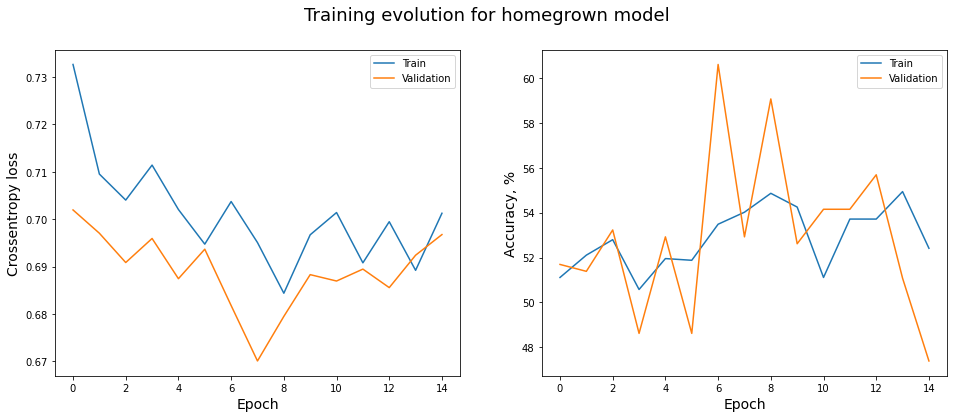

In [70]:
plt.figure(figsize=(16, 6))
plt.suptitle("Training evolution for homegrown model", fontsize=18)

plt.subplot(121)
plt.plot(hist_baseline["loss"], label="Train")
plt.plot(hist_baseline["val_loss"], label="Validation")
plt.legend()
plt.ylabel("Crossentropy loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)

plt.subplot(122)
plt.plot(np.array(hist_baseline["accuracy"]) * 100, label="Train")
plt.plot(np.array(hist_baseline["val_accuracy"]) * 100, label="Validation")
plt.legend()
plt.ylabel("Accuracy, %", fontsize=14)
plt.xlabel("Epoch", fontsize=14);

As you can see from the plot, the validation accuracy fluctuates around 50% point. Our model is no better than random guess !! 

### Classification Report on Test Data 

By right, you should have allocated some data as test set for your test model. Since our data is pretty small, we did not. But for the sake of having better idea how our model is faring on each class, let's just use our validation data for getting some hard numbers :)

In [71]:
y_pred = model_baseline.predict(validation_gen)
y_valid = np.array(validation_gen.classes)

In [72]:
train_gen.classes[:1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [73]:
print(y_pred)

[[0.4689213 ]
 [0.466643  ]
 [0.4725602 ]
 [0.4827168 ]
 [0.44858712]
 [0.46163166]
 [0.47577953]
 [0.46678883]
 [0.47535032]
 [0.47256473]
 [0.45703965]
 [0.46809548]
 [0.45175695]
 [0.47207806]
 [0.5036636 ]
 [0.46298033]
 [0.46431643]
 [0.47454545]
 [0.471475  ]
 [0.4652676 ]
 [0.45812216]
 [0.4630311 ]
 [0.4616287 ]
 [0.47200975]
 [0.4670581 ]
 [0.46974972]
 [0.45015877]
 [0.4611951 ]
 [0.46079504]
 [0.4652631 ]
 [0.45966667]
 [0.4641626 ]
 [0.47046682]
 [0.47405264]
 [0.4610222 ]
 [0.46330547]
 [0.4488723 ]
 [0.45059064]
 [0.46397364]
 [0.46597707]
 [0.48009256]
 [0.46991318]
 [0.4640425 ]
 [0.4906436 ]
 [0.4622009 ]
 [0.46324137]
 [0.467371  ]
 [0.4770138 ]
 [0.47132507]
 [0.46837398]
 [0.47608617]
 [0.44291276]
 [0.4730942 ]
 [0.46027654]
 [0.4591141 ]
 [0.4582146 ]
 [0.48011398]
 [0.47126487]
 [0.47298694]
 [0.45997337]
 [0.4695391 ]
 [0.46333182]
 [0.4538517 ]
 [0.46263912]
 [0.46642193]
 [0.46304795]
 [0.48652542]
 [0.46160614]
 [0.4654852 ]
 [0.48035067]
 [0.47555977]
 [0.48

In [74]:
print(classification_report(y_valid, y_pred.flatten() > 0.5))

              precision    recall  f1-score   support

           0       0.47      0.99      0.64       154
           1       0.50      0.01      0.01       171

    accuracy                           0.47       325
   macro avg       0.49      0.50      0.33       325
weighted avg       0.49      0.47      0.31       325



Looks like our model almost always predict 1 (Positive) emotion!